In [1]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

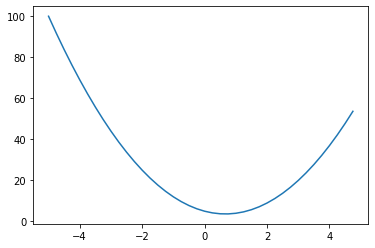

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Calculate derivative

h = 0.00000001
x = -3.0

(f(x + h) - f(x))/h

-22.00000039920269

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2  = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [8]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __repr__(self):
        return f"Value(data={self.data})"
    


In [9]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label='d'
e = d + c; e.label='e'
f = Value(-2.0, label='f')
L = e * f; L.label='L'
L

Value(data=-8.0)

In [11]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [12]:
L._op

'*'

In [13]:
#Visualize expression graph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [14]:
# Manually enter grad values.

L.grad = 1.0
e.grad = -2.0
f.grad = 4.0

d.grad = -2.0
c.grad = -2.0

a.grad = 6.0
b.grad = -4.0

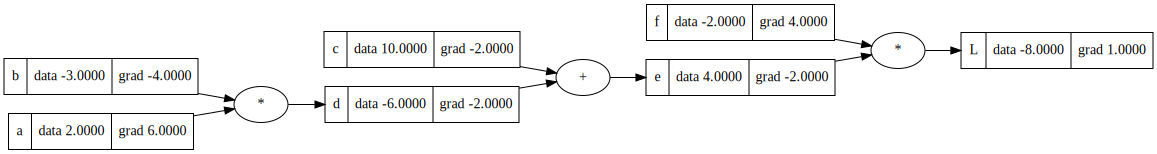

In [15]:
draw_dot(L)

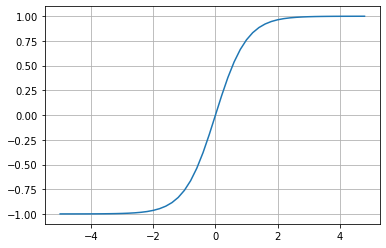

In [16]:
# Activation function - Tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Biological Neuron<br>
<img src="https://cs231n.github.io/assets/nn1/neuron.png" width="600"><br>
<br>
Mathematical Model<br>
<img src = "https://cs231n.github.io/assets/nn1/neuron_model.jpeg" width="600">

In [17]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'
# e = (2*n).exp()
# o = (e-1) / (e+1)

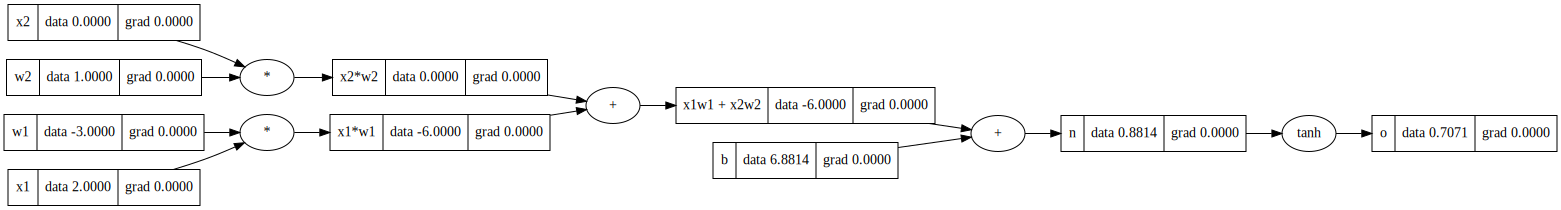

In [18]:
draw_dot(o)

In [19]:
# #Manual Backpropogation through neuron
# o.grad = 1.0

# # o = tanh(n)
# # do/dn = 1 - o**2
# n.grad = 1 - o.data**2

# # Plus operation - local distributer of derivative
# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# # Mult derviative - y of x & z
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

In [20]:
# o.grad = 1.0
# o._backward()

# n._backward()
# x1w1x2w2._backward()

# x1w1._backward()
# x2w2._backward()

In [21]:
# #Topological Sort
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# o.grad = 1.0
# for node in reversed(topo):
#     node._backward()

In [22]:
# #Accumlative gradient

# a = Value(3.0, label='a')
# b = a + a; b.label='b'
# b.backward()
# draw_dot(b)

In [23]:
o.backward()

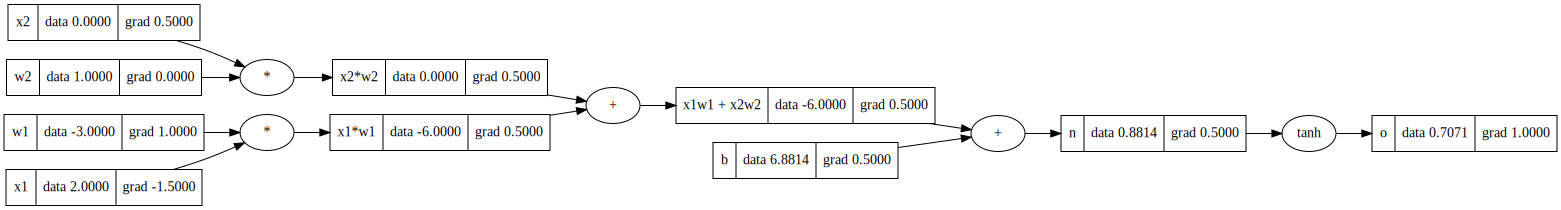

In [24]:
draw_dot(o)

In [25]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
          

In [26]:
x = [2.0, 3.0, -1.0]

# # Single neuron
# n = Neuron(2)
# n(x)

# # Layer of neurons
# n = Layer(2, 3)
# n(x)

# Multi-Layer Perceptron
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9628732003310335)

In [27]:
len(n.parameters())

41

In [28]:
n.parameters()

[Value(data=0.6096499861293359),
 Value(data=-0.7698918563110035),
 Value(data=-0.9817881421142083),
 Value(data=0.6046883217922245),
 Value(data=-0.17335054954921358),
 Value(data=0.13549165629487492),
 Value(data=-0.07889398955961546),
 Value(data=0.5810058177535364),
 Value(data=-0.44019901020415464),
 Value(data=0.16233770211582632),
 Value(data=0.4037418711430616),
 Value(data=0.35650528468639764),
 Value(data=-0.6256355189650338),
 Value(data=-0.7187105225795145),
 Value(data=0.07740002626575393),
 Value(data=0.6217453744720616),
 Value(data=0.6331545123538282),
 Value(data=0.25923480102062313),
 Value(data=0.28939308820408605),
 Value(data=-0.7711117252626263),
 Value(data=-0.6298268840811763),
 Value(data=-0.5033899768107231),
 Value(data=-0.16448964862497406),
 Value(data=-0.5845364330836478),
 Value(data=0.7308292710008848),
 Value(data=0.15920514630908777),
 Value(data=0.97548642633281),
 Value(data=0.8200494056266145),
 Value(data=-0.26571477862914006),
 Value(data=0.179619

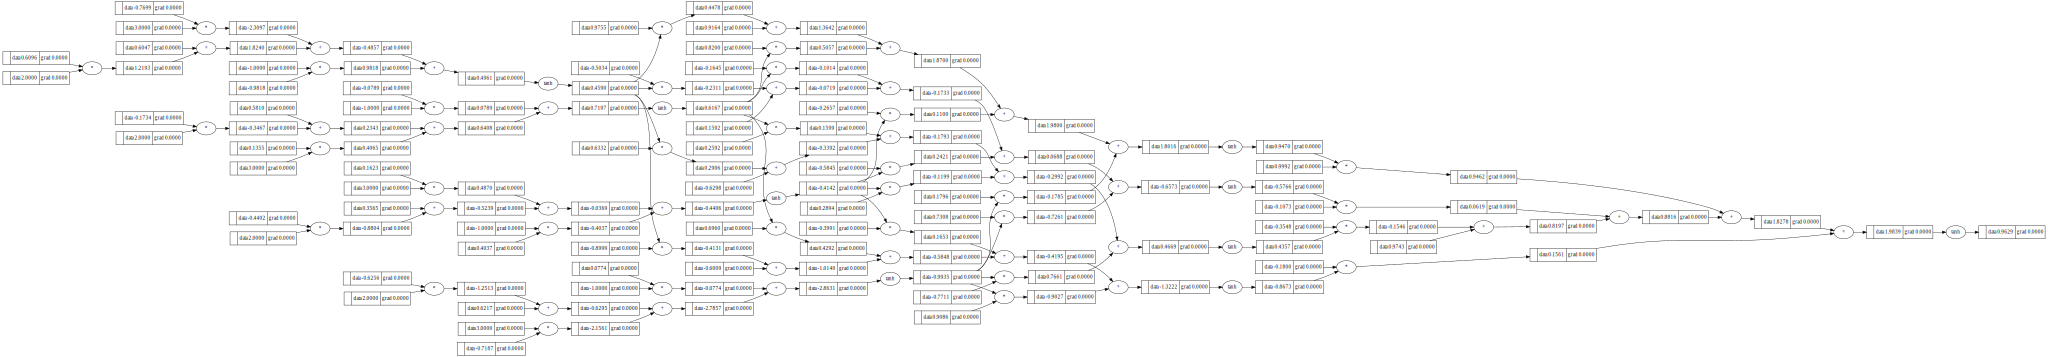

In [29]:
draw_dot(n(x))

In [30]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    ]

ys = [1.0, -1.0, -1.0, 1.0]

In [31]:
# ypred = [n(x) for x in xs]
# ypred

In [32]:
# #mean-squared error
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# loss

In [33]:
# n.layers[0].neurons[0].w[0].grad
# n.layers[0].neurons[0].w[0].data

In [34]:
for k in range(100):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))     #mean-squared error

    #backward pass
    for p in n.parameters(): # zero_grad
        p.grad = 0.0
    loss.backward()

    # update - stocastic gradient descent
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 7.57486965166873
1 7.311063959763345
2 6.554441903433205
3 4.659726994033321
4 3.56338565707931
5 2.92745051468438
6 2.4586556234294266
7 1.7752567318180523
8 0.9282061105601686
9 0.47622983966519866
10 0.17906110244559387
11 0.11635436540170077
12 0.09579471994582436
13 0.08305000086317786
14 0.0736925240786135
15 0.06633941253390321
16 0.06035175497243207
17 0.05536258260991328
18 0.05113451040972443
19 0.047503086337421126
20 0.04434930094678749
21 0.04158434113598877
22 0.039140355256454075
23 0.036964514962454884
24 0.03501503054533786
25 0.03325838958740474
26 0.03166739379988301
27 0.0302197335249133
28 0.02889693386646449
29 0.027683563279251977
30 0.02656663097057844
31 0.025535122347856272
32 0.024579636854330875
33 0.023692102732379018
34 0.022865550265553317
35 0.022093929952922888
36 0.021371965548230093
37 0.02069503439872582
38 0.020059069340713456
39 0.0194604777507845
40 0.01889607435040888
41 0.01836302511199664
42 0.017858800183592368
43 0.017381134184516058
44 0.0

In [35]:
ypred

[Value(data=0.9598175797822938),
 Value(data=-0.9558477338243178),
 Value(data=-0.9625891271623734),
 Value(data=0.9561107696361096)]

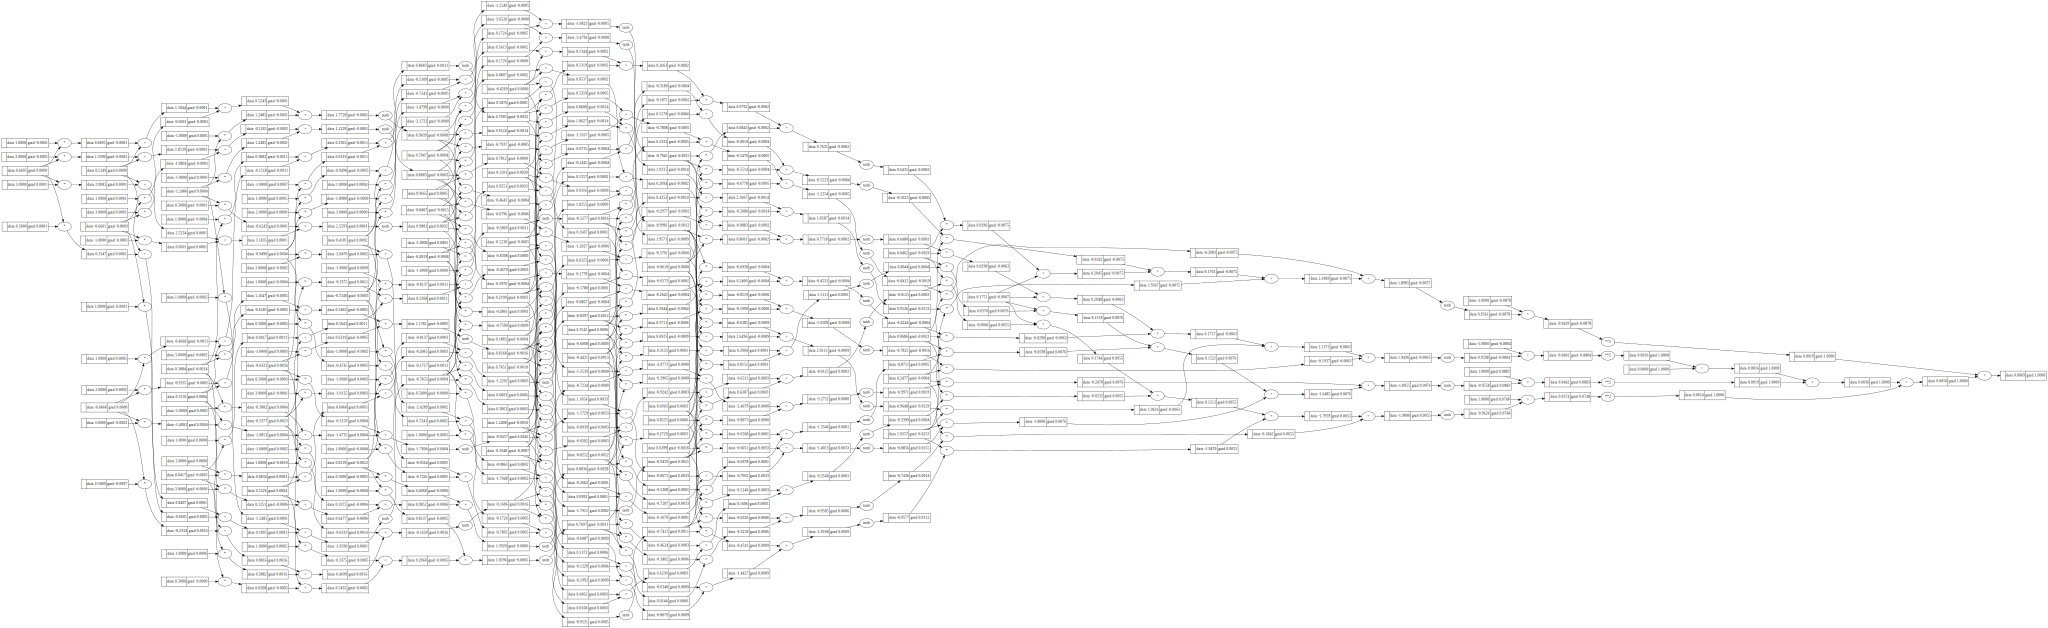

In [36]:
draw_dot(loss)